# Deep Q-learning algorithm

In this notebook we will test our implementaion of DQN on the CartPole environment. 

## Imports

In [1]:
from DQN import ReplayBuffer, DQN, training_dqn
import gymnasium as gym
import torch as torch
import matplotlib.pyplot as plt 

# Init the environment 

In [2]:
env = gym.make('CartPole-v1')
n_actions = env.action_space.n
obs_space_dim = env.observation_space.shape[0]
env_eval = gym.make('CartPole-v1')

## Training

In [8]:
model, store_loss, rewards = training_dqn(
    env=env,
    env_eval=env_eval,
    n_actions=n_actions,
    obs_space_dim=obs_space_dim,
    tau=0.05,
    gamma=0.99,
    n_steps=int(1e5),
    batch_size=32,
    update_freq=1000,
    hidden_dim=256
)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [14:57<00:00, 111.44it/s]


## Evaluation 

In [11]:
env_visual = gym.make('CartPole-v1', render_mode='human')
obs, info = env.reset()
terminated = False
truncated = False

for _ in range(10):

    R = 0

    obs, info = env_visual.reset()


    while terminated == False and truncated == False:

        with torch.no_grad():
            action = torch.argmax(model(torch.tensor(obs))).item()
        obs, reward, terminated, truncated, info = env_visual.step(action)
        R += reward

        env_visual.render()
    print(R)
    terminated = False
    truncated = False

env_visual.close()
    

185.0
225.0
219.0
370.0
211.0
192.0
435.0
288.0
332.0
349.0


### Save the model

In [23]:
torch.save(model, 'CartPole.pt')

## Plot the total reward during learning and evolution of the loss

Text(0, 0.5, 'Loss')

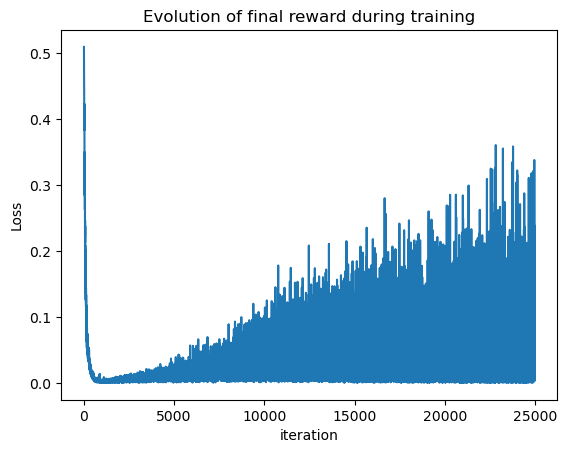

In [9]:
plt.plot(torch.tensor(store_loss).detach().numpy())
plt.title('Evolution of final reward during training')
plt.xlabel('iteration')
plt.ylabel('Loss')

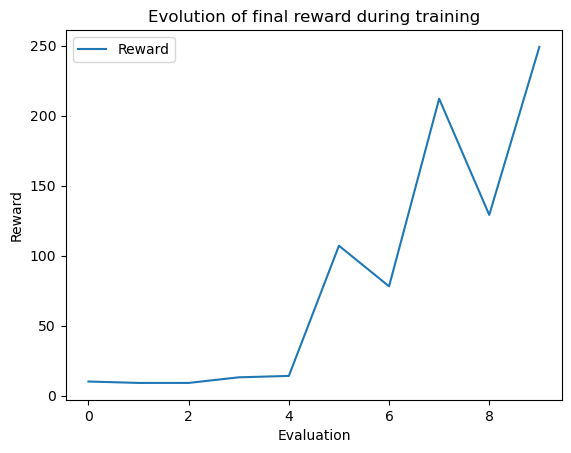

In [10]:
plt.plot(rewards, label='Reward')
plt.xlabel('Evaluation')
plt.ylabel('Reward')
plt.title('Evolution of final reward during training')
plt.legend()

## Vectorized DQN

This section provides the code to train DQN on mulitple environment in parallel

In [2]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch.nn as nn 
import torch

In [14]:
def training_dqn_vectorized(env, env_eval, n_env, n_actions, obs_space_dim, gamma, n_steps, tau, batch_size):
    """
    :param env: environement to learn the policy
    :param env_eval: environment for evaluation
    :param n_env: number of environment to run in parallel
    :param n_actions: number of possible actions
    :param obs_space_dim: dimension of the observation space
    :param gamma: dsicounted factor 
    :param n_steps: total number of timesteps to run
    :param tau: update factor for the update of the target network
    :param batch_size: batch size


    """
    

    store_loss = []
    reward_eval_list = []

    # set up espislon for exploration

    epsilon_treshold = 0.4

    replay_buffer_capacity = 1e6
    D = ReplayBuffer(replay_buffer_capacity)
    model = DQN(action_space_dim=n_actions, obs_space_dim=obs_space_dim, n_layers=2, layer_size=128, learning_rate=3e-4)
    target_network = DQN(action_space_dim=n_actions, obs_space_dim=obs_space_dim, n_layers=2, layer_size=128, learning_rate=4e-4)
    target_network.load_state_dict(model.state_dict())


    update_freq = 1000
    start_learning = 0

    state, info = env.reset()
    terminated = np.array([False for _ in range(n_env)])
    truncated = np.array([False for _ in range(n_env)])
    evaluation_rate = 10000

    state, info = env.reset()



    for t in tqdm(range(n_steps)):


        # select action

        if any(terminated) or any(truncated):

            state, info = env.reset()

        # random action to collect data

        if t < start_learning:

            action = env.action_space.sample()

        else:

            # exploration

            if np.random.random(1) <= epsilon_treshold:

                action = env.action_space.sample()
            
            # exploitation

            else:

                with torch.no_grad():

                    action = torch.argmax(model(torch.tensor(state)), dim=1).numpy()
        


        new_state, reward, terminated, truncated, info = env.step(action)

        for s, a, r, ns, term in zip(state, action, reward, new_state, terminated):

            D.store(torch.tensor(s), torch.tensor([a]), torch.tensor([r]), torch.tensor(ns), [term], t)

        state = new_state

        if t >= batch_size and t % 4 == 0:

            mini_batch = D.sample(batch_size=batch_size)

            loss = 0
            criterion = F.smooth_l1_loss

            actions = torch.cat([e[1].reshape((1, 1)) for e in mini_batch], dim=0)
            states = torch.cat([e[0].reshape((1, obs_space_dim)) for e in mini_batch], dim=0)
            rewards = torch.cat([e[2].reshape((1, 1)) for e in mini_batch], dim=0)
            next_states = torch.cat([e[3].reshape((1, obs_space_dim)) for e in mini_batch], dim=0)
            terminates = np.concatenate([e[4] for e in mini_batch])


            with torch.no_grad():
        
                y = rewards + gamma * torch.max(target_network(next_states), axis=1).values.reshape(batch_size, 1) * torch.tensor(1-terminates).reshape(batch_size, 1)
            
            loss += criterion(
                model.forward(states).gather(1, actions).reshape_as(y),
                y
                )
                
            model.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 100)

            model.optimizer.step()

            store_loss.append(loss / batch_size)
                
        if t%update_freq == 0:

            target_network_weight = target_network.state_dict()
            policy_weight = model.state_dict()

            for key in target_network_weight:

                target_network_weight[key] = tau * policy_weight[key] + (1-tau) * target_network_weight[key]
            
            target_network.load_state_dict(target_network_weight)
        
        if t%evaluation_rate == 0 and t!=0:

            R = 0

            obs_eval, info_eval = env_eval.reset()
            terminated_eval = np.array([False for _ in range(n_env)])
            truncated_eval = np.array([False for _ in range(n_env)])

            while any(terminated_eval) == False and any(truncated_eval) == False:
    
                with torch.no_grad():
                    action_eval = torch.argmax(model(torch.tensor(obs_eval)), dim=1).numpy()
            
                obs_eval, reward_eval, terminated_eval, truncated_eval, info_eval = env_eval.step(action_eval)
                R += reward_eval
            reward_eval_list.append(R)


            
    return model, store_loss, reward_eval_list

In [11]:
env_vec = gym.make_vec('CartPole-v1', num_envs=4)
env_vec_eval = gym.make_vec('CartPole-v1', num_envs=4)

In [5]:
n_actions = 2
obs_space_dim = 4

In [13]:
env_vec = gym.make_vec('CartPole-v1', num_envs=4)
env_vec_eval = gym.make_vec('CartPole-v1', num_envs=4)


model, store_loss, rewards = training_dqn_vectorized(
    env=env_vec,
    env_eval=env_vec_eval,
    n_env=4,
    n_actions=n_actions,
    obs_space_dim=obs_space_dim,
    tau=0.05,
    gamma=0.99,
    n_steps=int(5e4),
    batch_size=32
)

  0%|          | 0/50000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x4 and 2x128)

In [36]:
env_visual = gym.make('CartPole-v1', render_mode='human')
obs, info = env_visual.reset()
terminated = False
truncated = False

for _ in range(2):

    R = 0

    obs, info = env_visual.reset()

    t = 0
    while terminated == False and truncated == False:

        if t%4 == 0:

            with torch.no_grad():
                action = torch.argmax(model(torch.tensor(obs))).item()
        obs, reward, terminated, truncated, info = env_visual.step(action)
        R += reward

        env_visual.render()
    print(R)
    terminated = False
    truncated = False

env_visual.close()

-200.0
-200.0
